# Using Machine Learning to Forecast Air Quality in Beijing

## 4 - Machine Learning

### Import Python Packages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV, RidgeCV


from sklearn import linear_model

from pylab import rcParams
rcParams['figure.figsize'] = 20, 14
plt.style.use('fivethirtyeight')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


### Load cleaned data set

In [2]:
df = pd.read_csv('data/df_with_lags_and_horizons.csv', index_col=0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 6
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   horizon       1456 non-null   int64  
 1   date_origin   1456 non-null   object 
 2   date_target   1456 non-null   object 
 3   target        1456 non-null   float64
 4   stl_lag_1     1456 non-null   float64
 5   stl_lag_2     1456 non-null   float64
 6   stl_lag_3     1456 non-null   float64
 7   stl_lag_4     1456 non-null   float64
 8   stl_lag_5     1456 non-null   float64
 9   stl_lag_6     1456 non-null   float64
 10  stl_lag_7     1456 non-null   float64
 11  stl_lag_8     1456 non-null   float64
 12  stl_lag_9     1456 non-null   float64
 13  stl_lag_10    1456 non-null   float64
 14  stl_lag_11    1456 non-null   float64
 15  stl_lag_12    1456 non-null   float64
 16  stl_lag_13    1456 non-null   float64
 17  arima_lag_1   1456 non-null   float64
 18  arima_lag_2   1456 non-null   f

,horizon,date_origin,date_target,target,stl_lag_1,stl_lag_2,stl_lag_3,stl_lag_4,stl_lag_5,stl_lag_6,...,arima_lag_4,arima_lag_5,arima_lag_6,arima_lag_7,arima_lag_8,arima_lag_9,arima_lag_10,arima_lag_11,arima_lag_12,arima_lag_13
0,1,2011-12-31,2012-01-01,72.250000,163.666667,136.625000,61.750000,160.500000,198.875000,145.833333,...,160.500000,198.875000,145.833333,85.625000,43.333333,54.625000,30.416667,20.854167,84.375000,62.791667
1,2,2011-12-31,2012-01-02,63.416667,72.250000,163.666667,136.625000,61.750000,160.500000,198.875000,...,61.750000,160.500000,198.875000,145.833333,85.625000,43.333333,54.625000,30.416667,20.854167,84.375000
2,3,2011-12-31,2012-01-03,14.791667,59.233902,72.250000,163.666667,136.625000,61.750000,160.500000,...,136.625000,61.750000,160.500000,198.875000,145.833333,85.625000,43.333333,54.625000,30.416667,20.854167
3,4,2011-12-31,2012-01-04,33.833333,141.421644,59.233902,72.250000,163.666667,136.625000,61.750000,...,163.666667,136.625000,61.750000,160.500000,198.875000,145.833333,85.625000,43.333333,54.625000,30.416667
4,5,2011-12-31,2012-01-05,117.208333,73.739829,141.421644,59.233902,72.250000,163.666667,136.625000,...,72.250000,163.666667,136.625000,61.750000,160.500000,198.875000,145.833333,85.625000,43.333333,54.625000


In [3]:
# Generating a 7 day forecast for the first week of 2014

BURN_IN = "2012-01-01"
FORECAST_START = "2015-01-01"
FORECAST_END = "2015-12-31"
FORECAST_DAYS = 7

In [4]:
timestamps = pd.date_range(start=BURN_IN, end=FORECAST_END, freq='W')

In [5]:
def split_train_test(df, target_col, date_target_col, date_origin_col, split_date, days):

    train = df[df[date_target_col] < split_date] 
    test = df[df[date_target_col] >= split_date].head(days)
    dates = test[date_target_col]
    X_train = train.drop(target_col, axis=1)
    y_train = train[target_col]
    X_test = test.drop(target_col, axis=1)
    y_test = test[target_col]
    
    return(X_train, X_test, y_train, y_test, dates)

In [6]:
def plot_feature_importance(coef, labels):

    plt.figure()

    indices = np.argsort(coef)
    plt.barh(range(len(indices)),coef[indices])
    plt.yticks(range(len(indices)), labels[indices])
    plt.xlabel("Feature Importance")

    plt.show()

In [7]:
def plot_forecast(df, col_target_date, col_y_test, col_y_pred, horizon):

    fig, ax = plt.subplots(1, 1)

    plt.plot(col_target_date, col_y_test, data=df, linewidth=1.5)
    plt.scatter(x=col_target_date, y=col_y_pred, c=horizon, data=df)
    cb = plt.colorbar()
    cb.set_label("Horizon")
    plt.ylabel("PM2.5 Concentration")
    plt.title("Comparison of Weekly Predictions Across Horizons with Actual PM2.5 Concentration Measurements");

    dates_labels = df[col_target_date].values[::28]

    ax.set(xticks=dates_labels, xticklabels=dates_labels);
    plt.xticks(rotation=90);

    plt.show()

In [8]:
def fit_ML(model, df, timestamps, target_col, date_target_col, date_origin_col, start_date, days, drop_cols):

    timestamps = timestamps[timestamps >= start_date]

    results = []

    for timestamp in timestamps[:-1]:

        X_train, X_test, y_train, y_test, dates = split_train_test(df=df, target_col=target_col, date_target_col=date_target_col, date_origin_col=date_origin_col, split_date=timestamp.strftime('%Y-%m-%d'), days=days)

        model.fit(X_train.drop(drop_cols, axis=1), y_train)
        y_pred = model.predict(X_test.drop(drop_cols, axis=1))
        coef = model.coef_

        df_results = pd.DataFrame({
            'target_date': dates,
            'horizon': list(range(1,days+1)),
            'y_test': y_test.values,
            'y_pred': y_pred
        })

        results.append(df_results)

    df = pd.concat(results)

    plot_feature_importance(coef=coef, labels=X_train.drop(drop_cols, axis=1).columns)

    plot_forecast(df=df, col_target_date='target_date', col_y_test='y_test', col_y_pred='y_pred', horizon='horizon')

    return df

In [9]:
def calculate_rmse(ytest, ypred):

    se = [(ytest - ypred)**2 for (ytest, ypred) in zip(ytest, ypred)]
    rmse = (sum(se) / len(se))**0.5
    
    return rmse

In [10]:
def calculate_rmse_by_horizon(df, col_horizon, ytest, ypred):

    horizons = list(set(df[col_horizon]))
    rmses = []

    for horizon in horizons:
        df_horizon = df[df[col_horizon] == horizon]
        rmses.append(calculate_rmse(df_horizon[ytest], df_horizon[ypred]))

    df_rmse = pd.DataFrame({
        'horizon': horizons,
        'rmse': rmses
    })
    
    return df_rmse

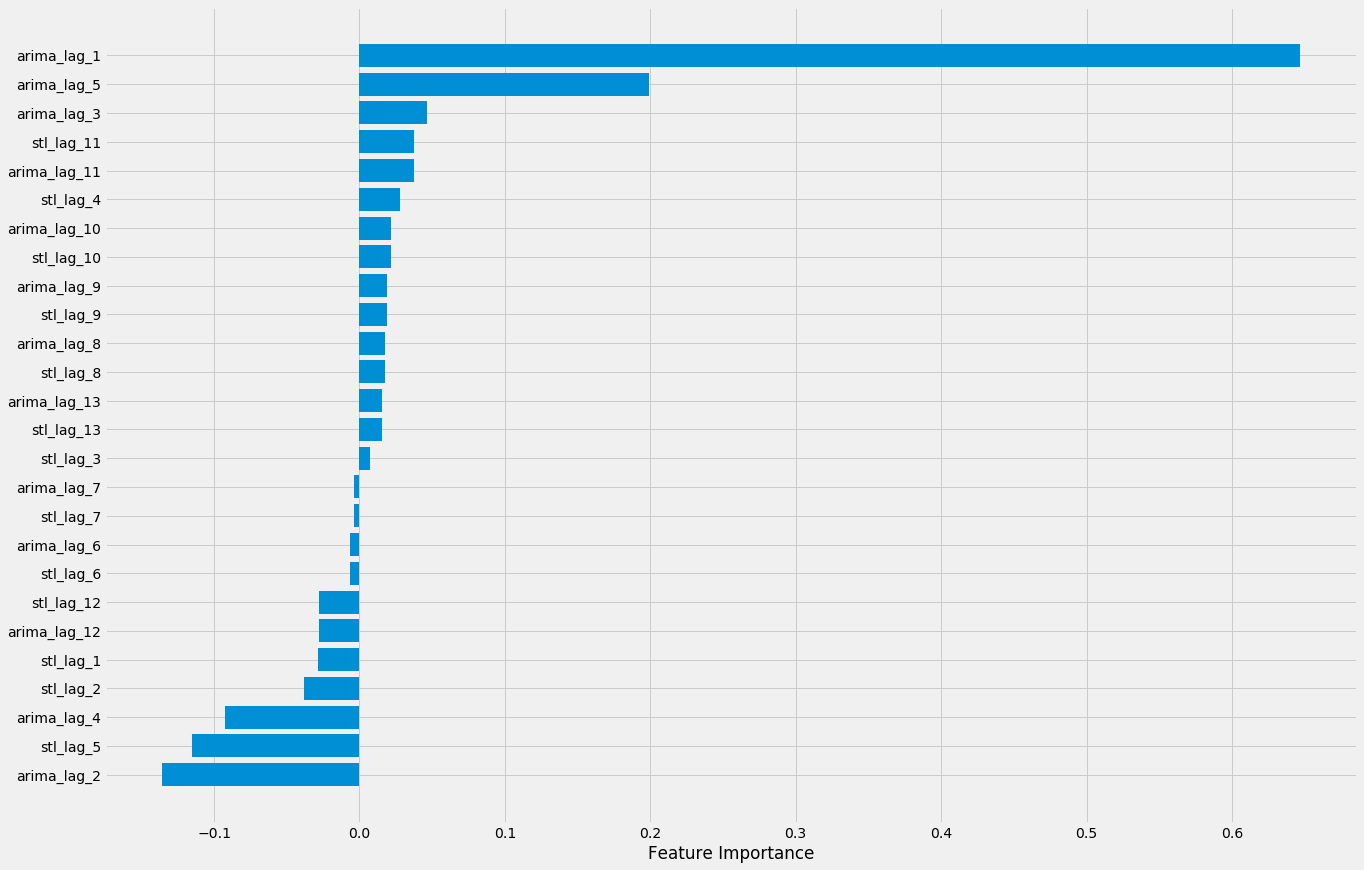

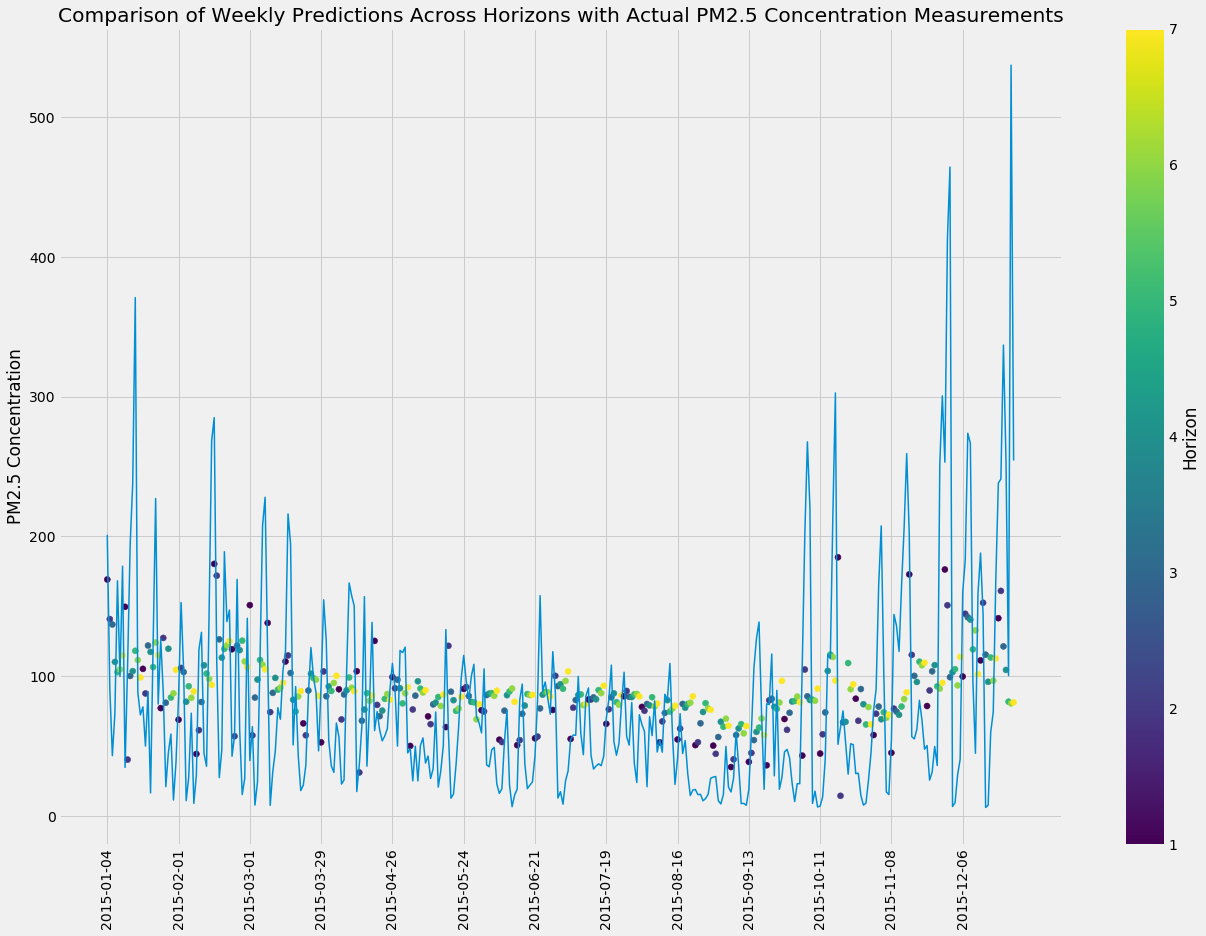

In [11]:
RidgeCV_results = fit_ML(model=linear_model.RidgeCV(), df=df, timestamps=timestamps, target_col='target', date_target_col='date_target', date_origin_col='date_origin', start_date=FORECAST_START, days=7, drop_cols=['horizon', 'date_origin', 'date_target'])

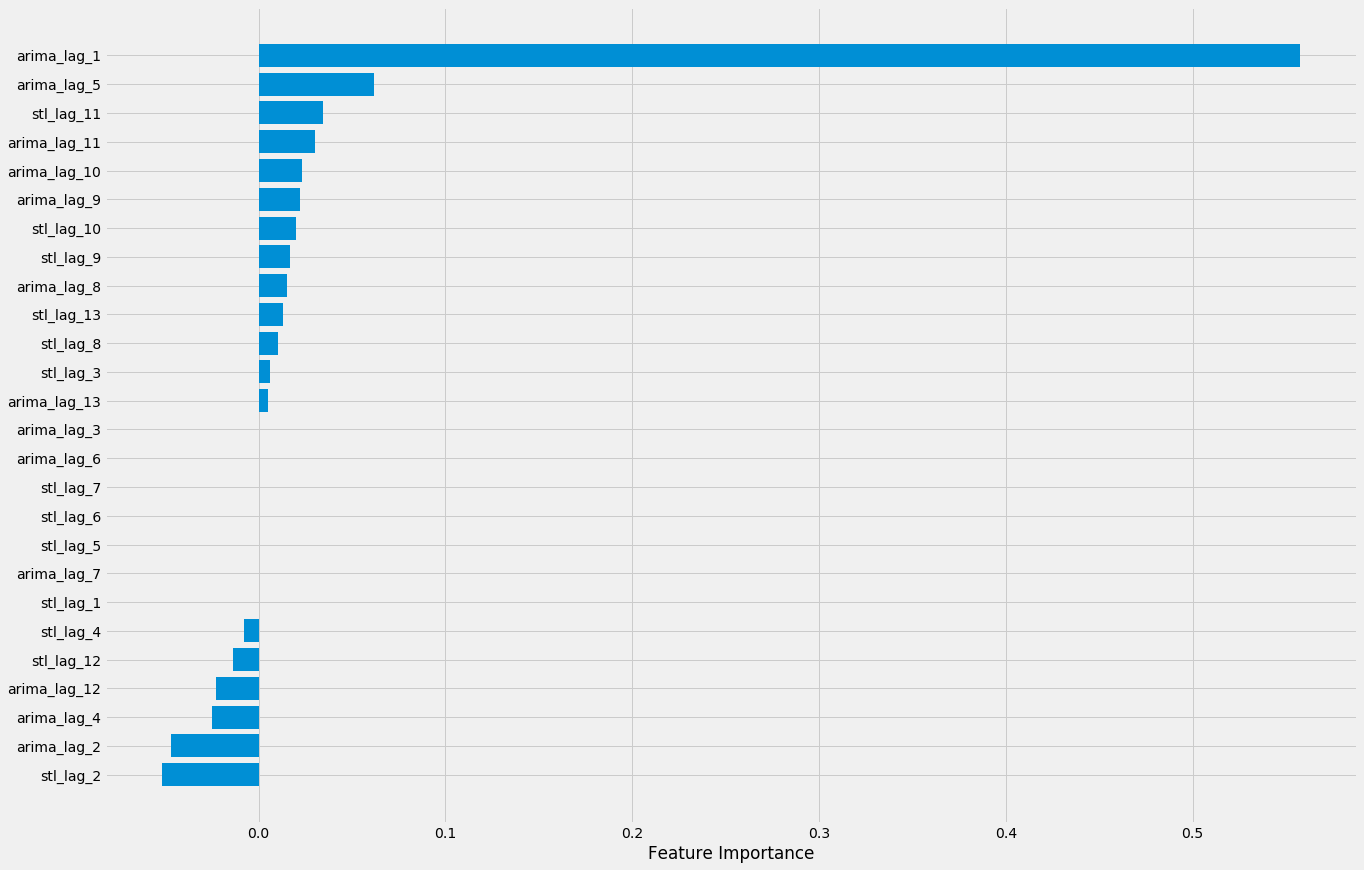

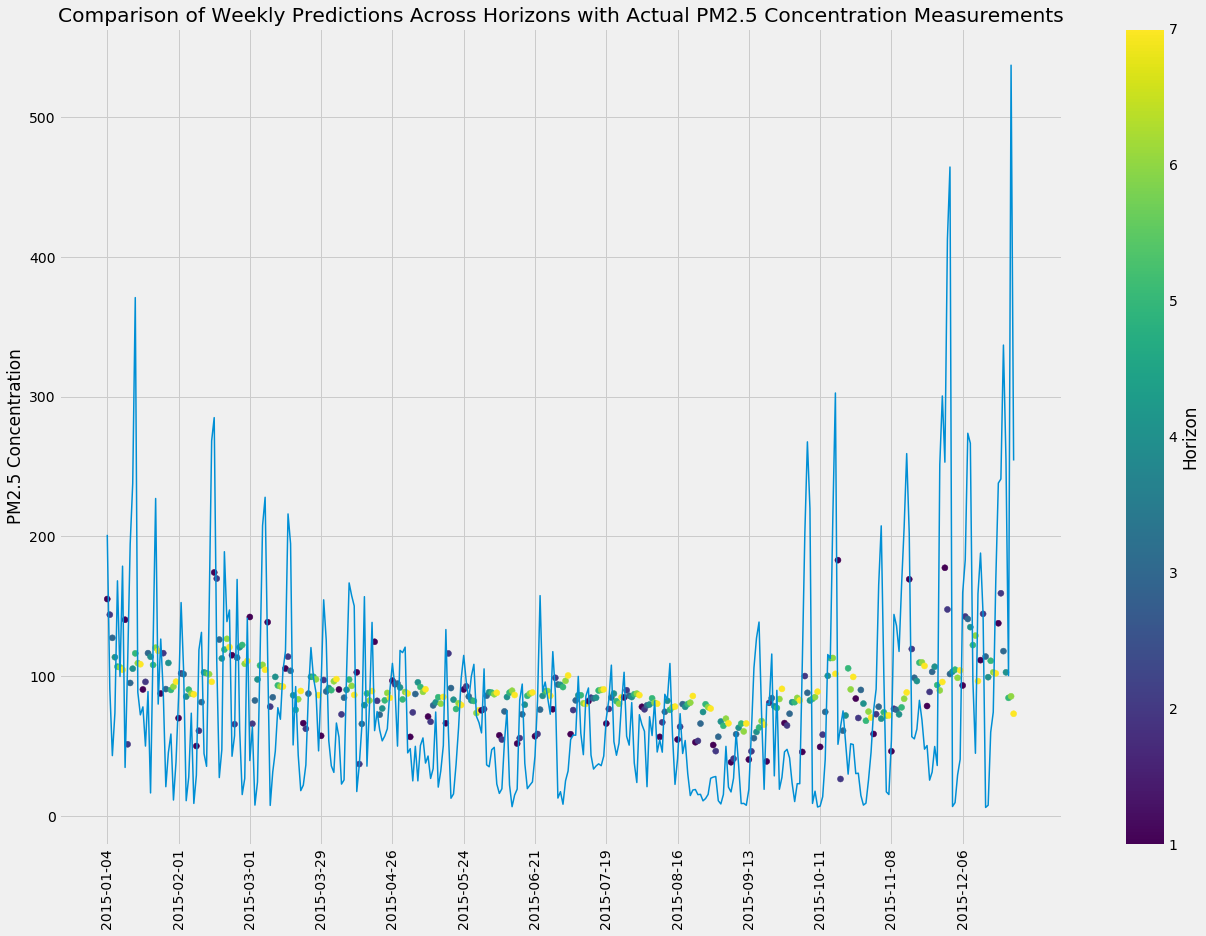

In [12]:
ElasticNetCV_results = fit_ML(model=linear_model.ElasticNetCV(), df=df, timestamps=timestamps, target_col='target', date_target_col='date_target', date_origin_col='date_origin', start_date=FORECAST_START, days=7, drop_cols=['horizon', 'date_origin', 'date_target'])

In [13]:
ElasticNetCV_results

,target_date,horizon,y_test,y_pred
0,2015-01-04,1,201.166667,155.223092
1,2015-01-05,2,90.875000,144.018450
2,2015-01-06,3,43.166667,127.439831
3,2015-01-07,4,73.666667,113.602432
4,2015-01-08,5,168.250000,106.836263
...,...,...,...,...
2,2015-12-22,3,336.958333,117.934428
3,2015-12-23,4,254.541667,102.769834
4,2015-12-24,5,100.416667,84.500716
5,2015-12-25,6,537.250000,85.622440


In [14]:
RidgeCV_results

,target_date,horizon,y_test,y_pred
0,2015-01-04,1,201.166667,169.197625
1,2015-01-05,2,90.875000,140.864277
2,2015-01-06,3,43.166667,137.025539
3,2015-01-07,4,73.666667,110.220115
4,2015-01-08,5,168.250000,102.917558
...,...,...,...,...
2,2015-12-22,3,336.958333,121.327962
3,2015-12-23,4,254.541667,104.498022
4,2015-12-24,5,100.416667,81.758834
5,2015-12-25,6,537.250000,80.564713


### Compare ElasticNetCV and RidgeCV Predictions

In [15]:
df_ElasticNetCV_rmse = calculate_rmse_by_horizon(df=ElasticNetCV_results, col_horizon="horizon", ytest="y_test", ypred="y_pred")

In [16]:
df_RidgeCV_rmse = calculate_rmse_by_horizon(df=RidgeCV_results, col_horizon="horizon", ytest="y_test", ypred="y_pred")

In [17]:
df_rmse = pd.merge(left=df_ElasticNetCV_rmse, right=df_RidgeCV_rmse, on='horizon')

In [18]:
df_rmse

,horizon,rmse_x,rmse_y
0,1,50.732707,51.259443
1,2,56.783923,56.300747
2,3,85.571087,85.757741
3,4,65.681690,65.604628
4,5,63.523493,63.613600
5,6,86.478098,86.652090
6,7,77.402213,77.211023


Text(0.5, 1.0, 'Comparison of ElasticNetCV and RidgeCV RMSE')

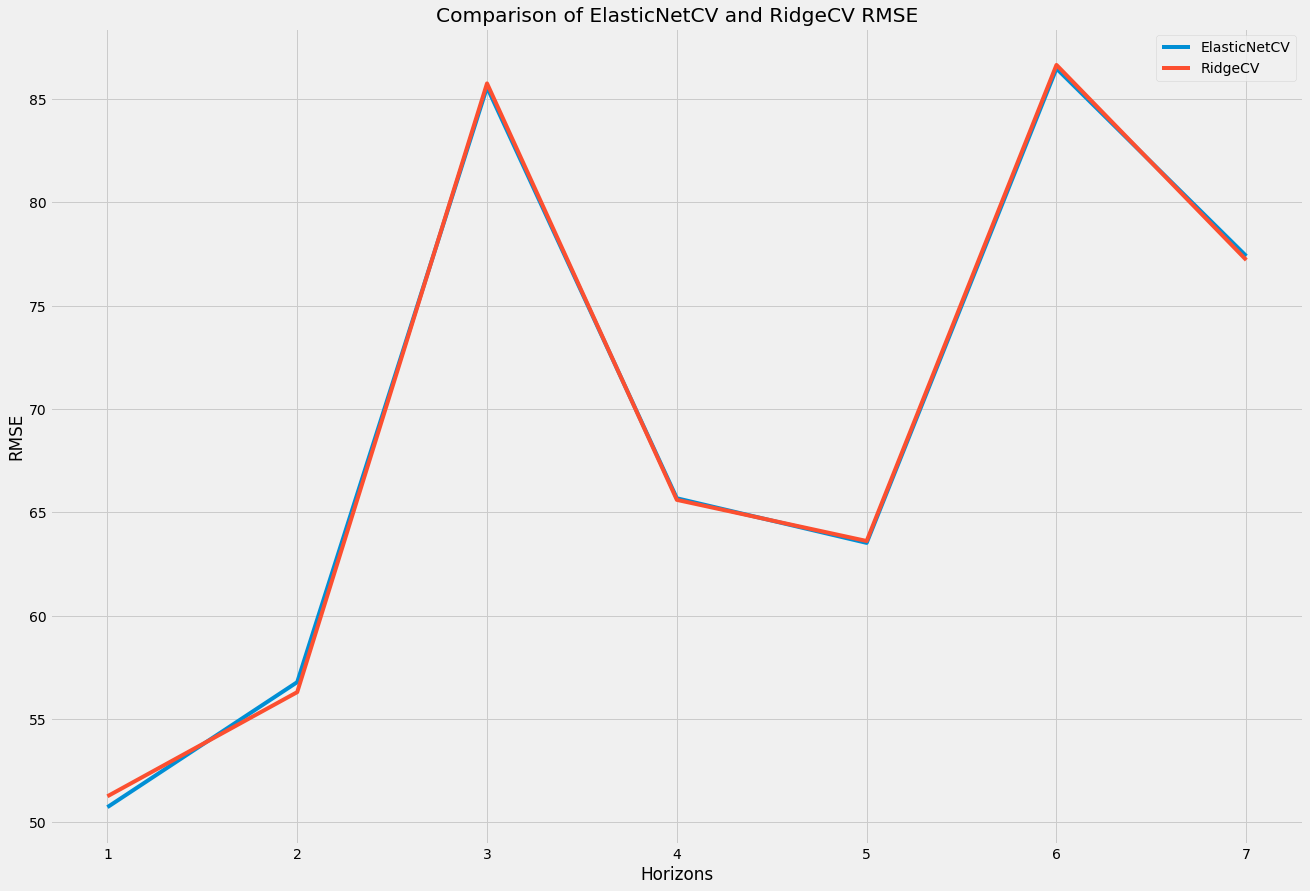

In [19]:
plt.figure()
plt.plot(df_rmse.horizon, df_rmse.rmse_x)
plt.plot(df_rmse.horizon, df_rmse.rmse_y)
plt.legend(['ElasticNetCV', 'RidgeCV'])
plt.xlabel('Horizons')
plt.ylabel('RMSE')
plt.title('Comparison of ElasticNetCV and RidgeCV RMSE')